In [1]:
# ! pip install pandas numpy matplotlib scikit-learn mlxtend tensorflow keras
# ! pip install --upgrade keras
# ! pip install np_utils
# ! pip install ipywidgets

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras import models
from keras.utils import to_categorical

from tensorflow import convert_to_tensor
from tensorflow.image import grayscale_to_rgb
from tensorflow.data import Dataset
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [3]:
data = pd.read_csv('https://github.com/unclethien/Facial-Expression-Recognition/raw/main/Dataset/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
# As the pretrained model expects rgb images, we convert our grayscale images with a single channel to pseudo-rgb images with 3 channels
train_images_rgb = grayscale_to_rgb(convert_to_tensor(train_images))
val_images_rgb = grayscale_to_rgb(convert_to_tensor(val_images))
test_images_rgb =  grayscale_to_rgb(convert_to_tensor(test_images))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_rgb_datagen = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)

train_rgb_datagen.fit(train_images_rgb)

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

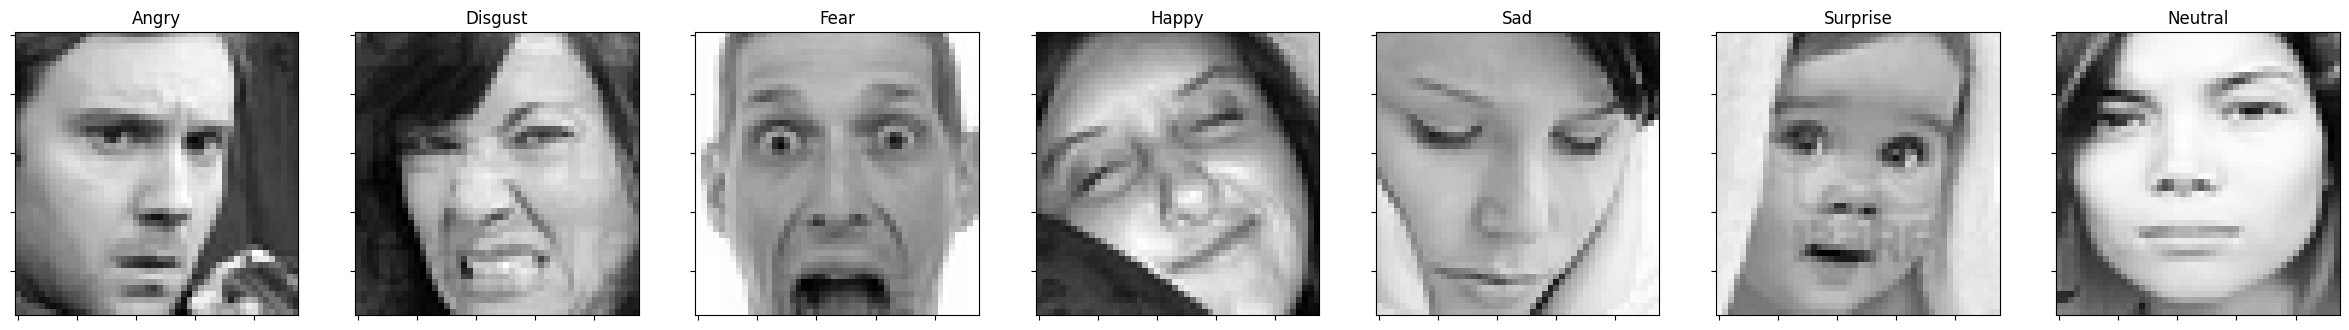

In [12]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

plot_all_emotions()

In [13]:
#Plot 5 examples of one emotion
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

#### Angry

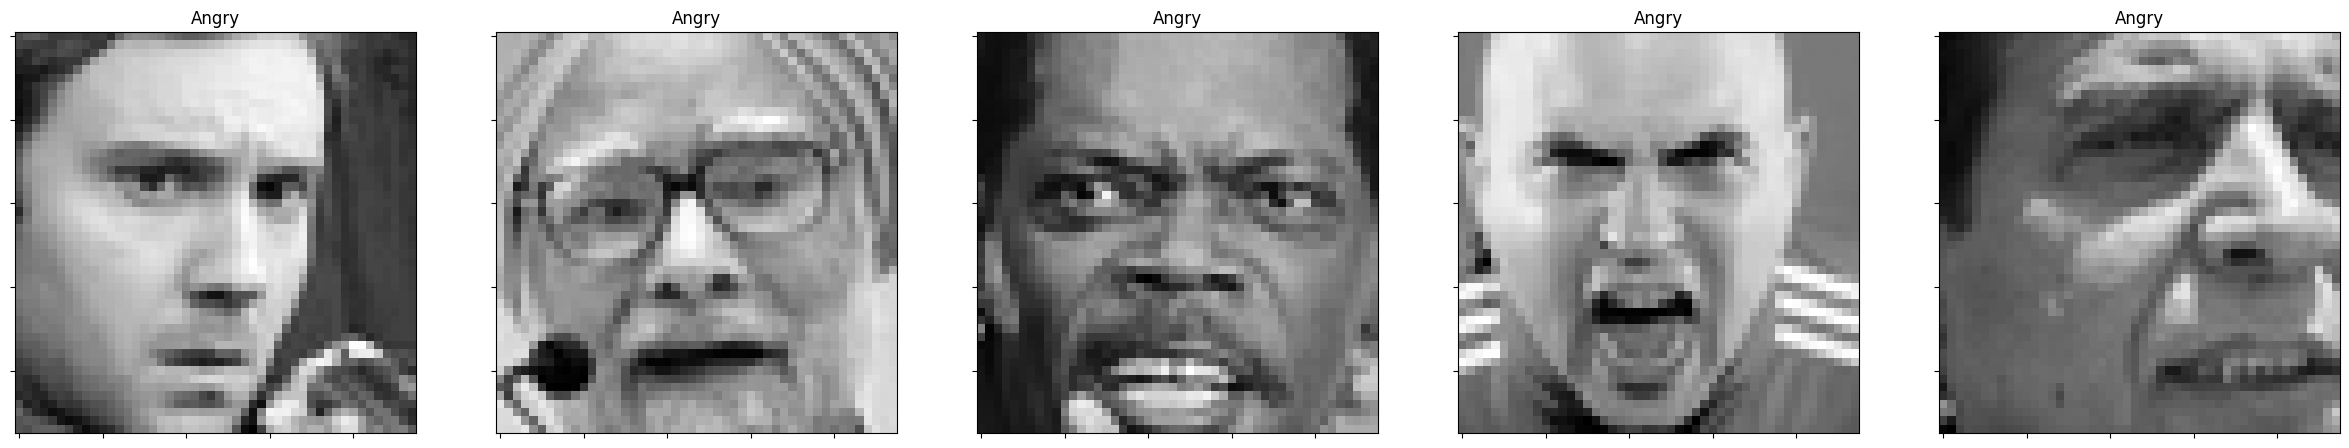

In [14]:
plot_examples(label=0)

#### Digust

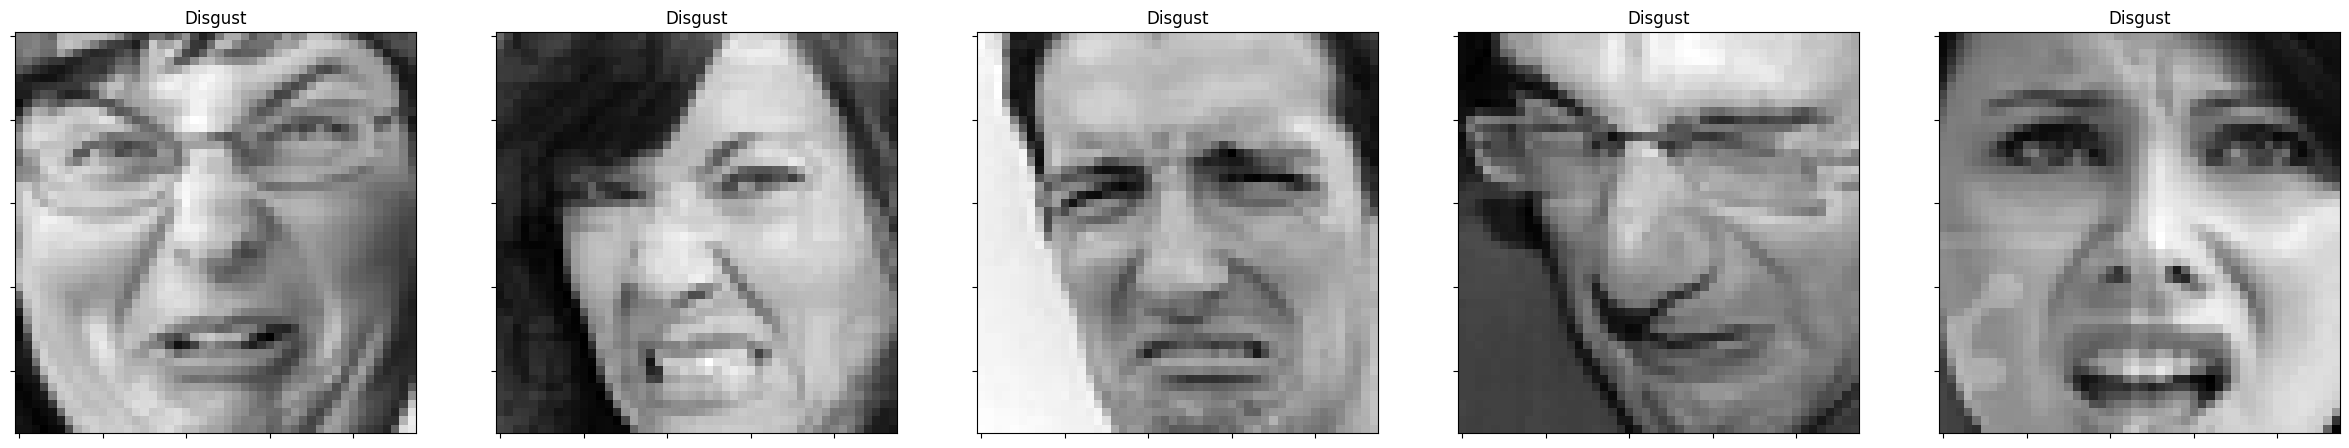

In [15]:
plot_examples(label=1)

#### Fear

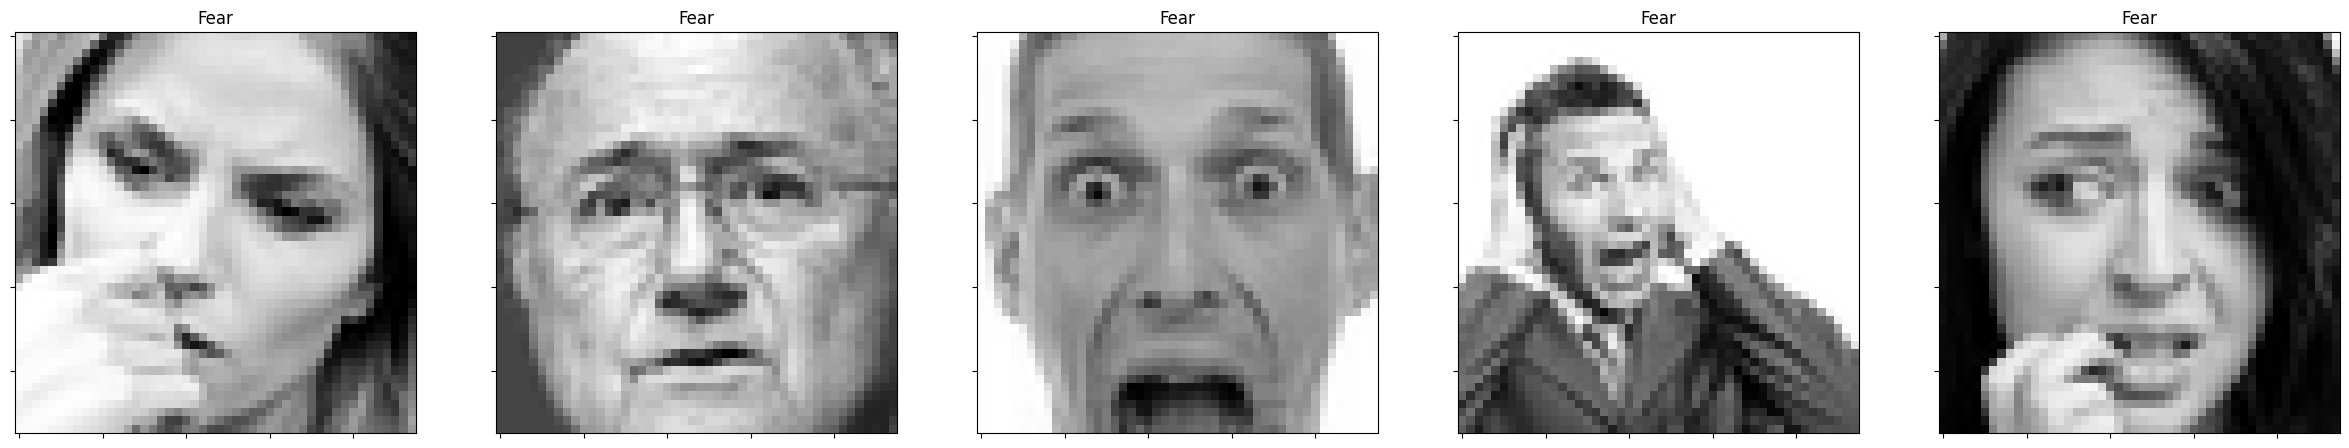

In [16]:
plot_examples(label=2)

#### Happy

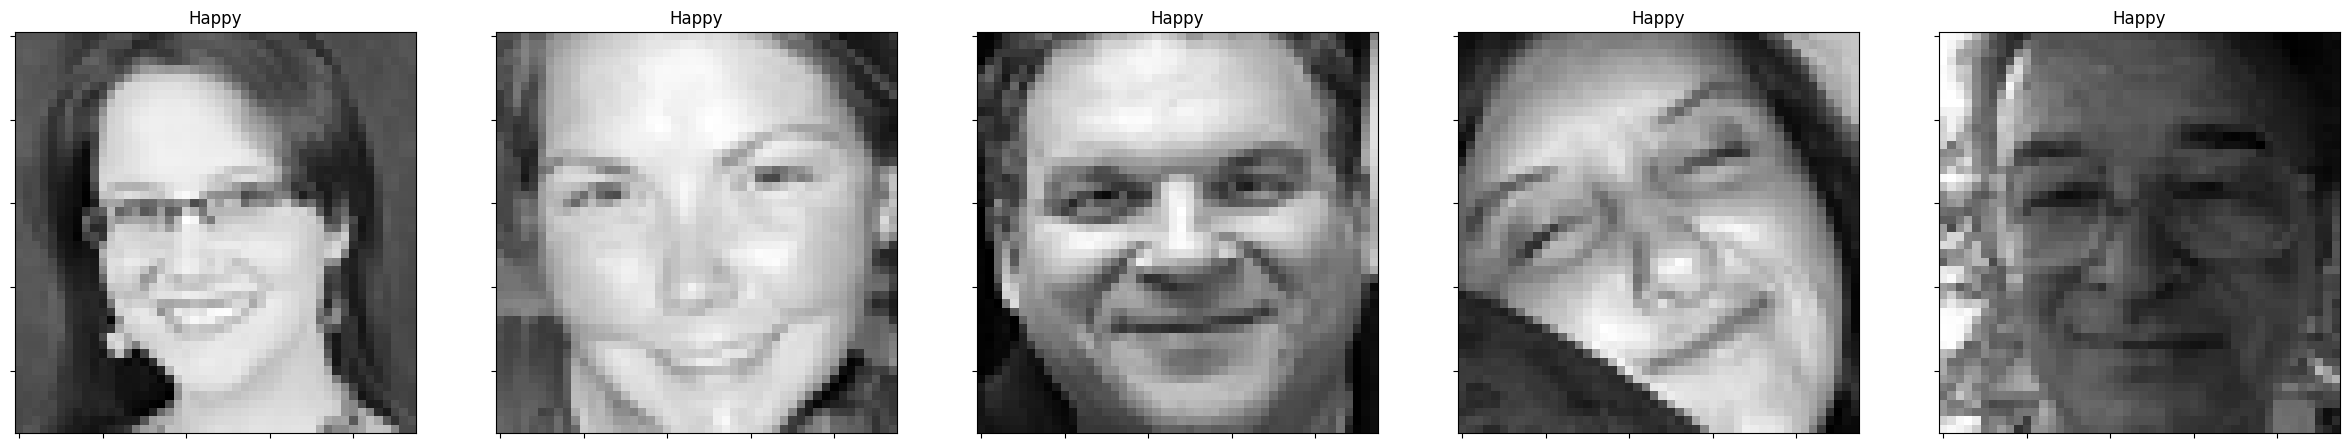

In [17]:
plot_examples(label=3)

#### Surprise

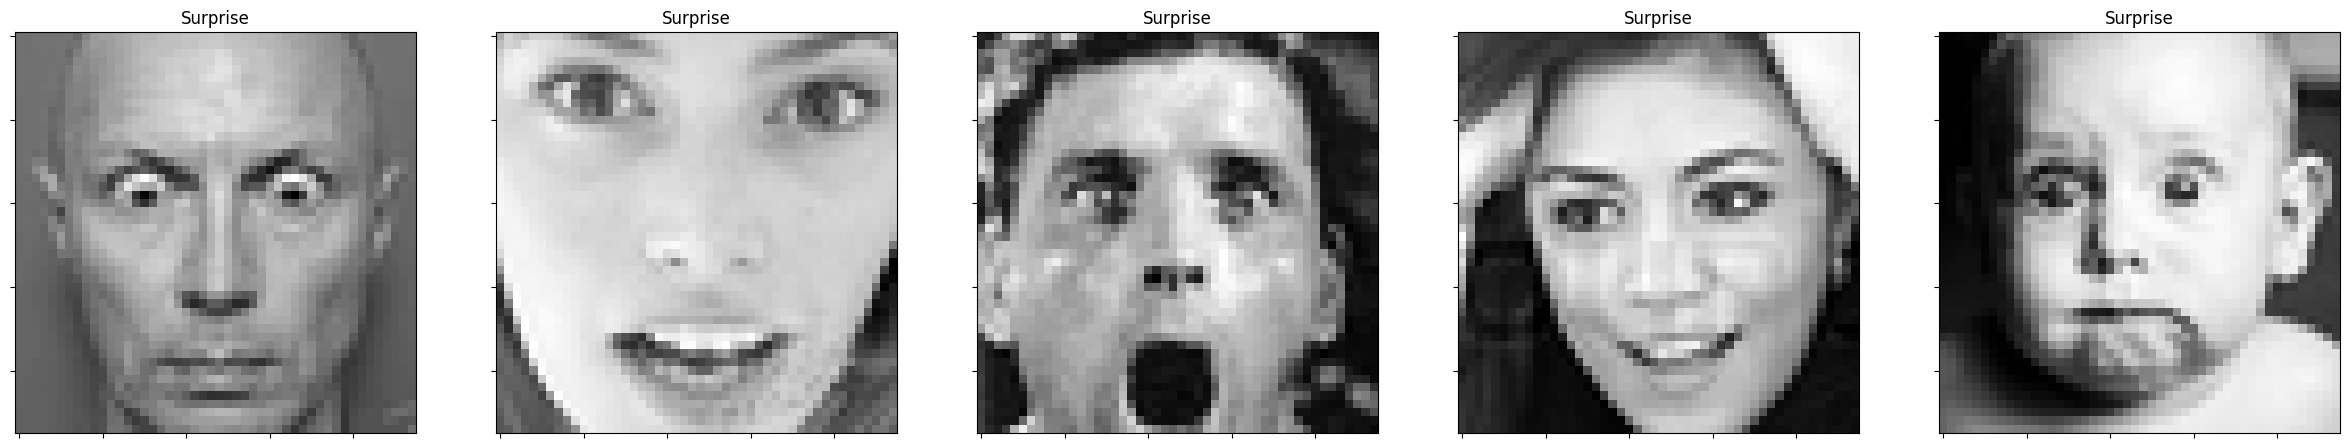

In [18]:
plot_examples(label=5)

#### Neutral

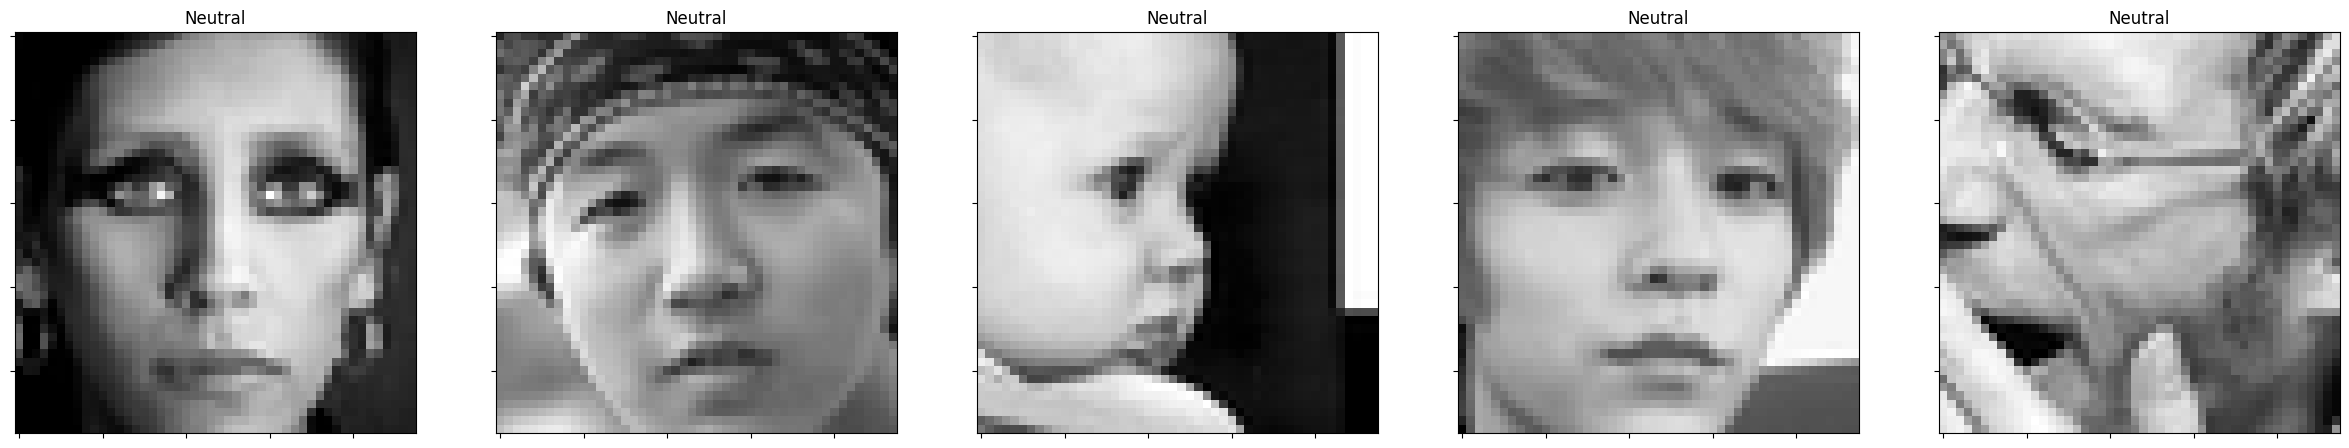

In [19]:
plot_examples(label=6)

In [20]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

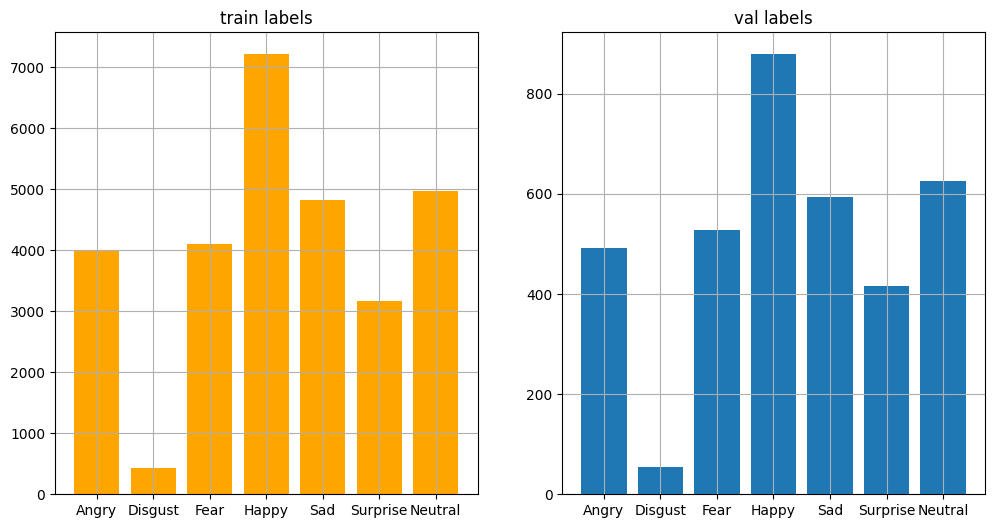

In [21]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [22]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight



{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [23]:
#Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    filepath="best_model.h5",
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto') 
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint
]

In [24]:
#General shape parameters
IMG_SIZE = 48
NUM_CLASSES = 7
BATCH_SIZE = 64

In [25]:
#A plotting function to visualize training progress
def render_history(history, suf=''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.95,
                        top=0.9,
                        wspace=0.4)
    
    ax1.set_title("Losses")
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('value of the loss function')
    ax1.legend()

    ax2.set_title("Accuracies")
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('value of accuracy')
    ax2.legend()
    
    plt.show()
    suf = '' if suf == '' else '_'+suf
    fig.savefig('loss_and_acc'+suf +'.png')

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

#By specifying the include_top=False argument, we load a network that 
#doesn't include the  classification layers at the top, which is ideal for feature extraction.
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

#plot_model(base_net, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet_full.png')

In [27]:
base_model = Model(inputs = base_model.input,outputs = base_model.get_layer('block_12_project_BN').output, name = 'mobilenet_trunc')


In [28]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import Input, Model

global_average_layer = GlobalAvgPool2D()
prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs_raw, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs=inputs_raw, outputs= outputs)


In [29]:
from keras.optimizers import Adam
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 3, 3, 96)          558656    
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 96)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 679       
                                                                 
Total params: 559335 (2.13 MB)
Trainable params: 679 (2.65 KB)
Non-trainable params: 558656 (2.13 MB)
_________________________________________________________________


In [30]:
initial_epochs = 5
history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                 train_labels, 
                                                 batch_size=BATCH_SIZE),
                              validation_data=(val_images_rgb, 
                                               val_labels),
                              class_weight = class_weight,
                              steps_per_epoch=len(train_images) / BATCH_SIZE,
                              #initial_epoch = history.epoch[-1],
                              #epochs = total_epochs,
                              epochs = initial_epochs,
                              callbacks=callbacks)

C:\Users\thien\AppData\Local\Temp\ipykernel_21880\3261094124.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


Epoch 1/5
449/448 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.2324
Epoch 1: val_accuracy improved from -inf to 0.28253, saving model to best_model.h5


c:\Users\thien\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 30s 62ms/step - loss: 0.3470 - accuracy: 0.2324 - val_loss: 1.8869 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 2/5
449/448 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.3055
Epoch 2: val_accuracy improved from 0.28253 to 0.31067, saving model to best_model.h5
448/448 [==============================] - 28s 62ms/step - loss: 0.2760 - accuracy: 0.3055 - val_loss: 1.8235 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 3/5
449/448 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.3305
Epoch 3: val_accuracy improved from 0.31067 to 0.32070, saving model to best_model.h5
448/448 [==============================] - 28s 63ms/step - loss: 0.2662 - accuracy: 0.3305 - val_loss: 1.7510 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 4/5
449/448 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.3407
Epoch 4: val_accuracy improved from 0.32070 to 0.33380, saving model to best_model.h5
448/448 [==========

In [31]:
iterative_finetuning = True 

In [32]:
if iterative_finetuning:
    ftsuf = 'ft_2'
else:
    ftsuf = 'ft_atonce'


In [33]:

print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-37:]: #blocks 7-12
  layer.trainable = True
optims = {'adam': optimizers.Adam(0.001)}

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims['adam'],
        metrics=['accuracy']
)

model.summary()

Number of layers in the base model:  115
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 3, 3, 96)          558656    
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 96)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 679       
                                                                 
Total params: 559335 (2.13 MB)
Trainable params: 382823 (1.46 MB)
Non-trainable params: 176512 (689.50 KB)
_____________________________________________

In [34]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                train_labels, 
                                                batch_size=BATCH_SIZE),
                            validation_data=(val_images_rgb, 
                                            val_labels),
                            class_weight = class_weight,
                            steps_per_epoch=len(train_images) / BATCH_SIZE,
                            initial_epoch = history.epoch[-1],
                            epochs = total_epochs,
                            callbacks=callbacks)

Epoch 5/104


C:\Users\thien\AppData\Local\Temp\ipykernel_21880\3955368280.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


163/448 [=========>....................] - ETA: 19s - loss: 0.3087 - accuracy: 0.3164

In [ ]:
test_loss, test_acc = model.evaluate(test_images_rgb, test_labels) #, test_labels
print('test caccuracy:', test_acc)


113/113 [==============================] - 3s 23ms/step - loss: 1.1953 - accuracy: 0.5743
test caccuracy: 0.5742546916007996


In [ ]:
pred_test_labels = model.predict(test_images_rgb)

113/113 [==============================] - 3s 22ms/step


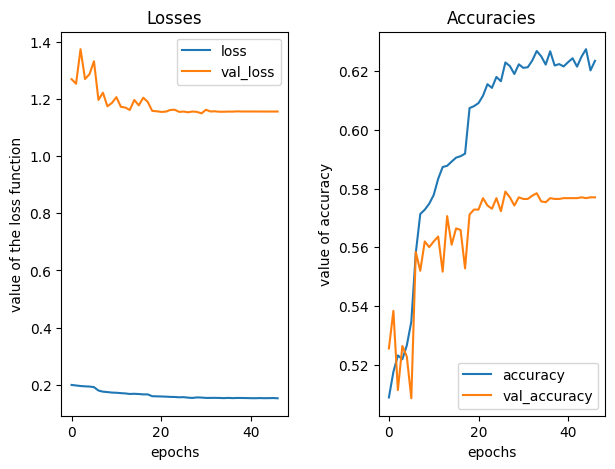

In [ ]:
ftsuf = 'ft_2'
render_history(history, 'mobilenet12blocks_wdgenaug_'+ftsuf)

In [ ]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

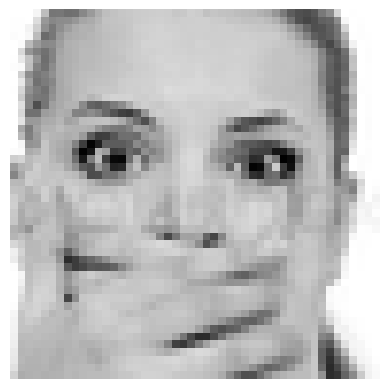

True Label: Fear
Predicted Label: Surprise
------------------------


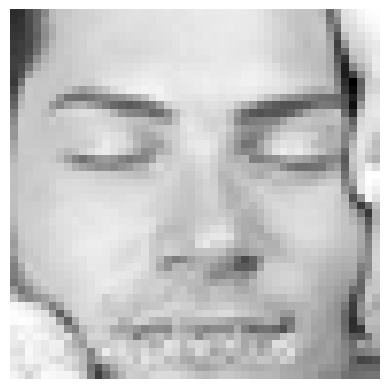

True Label: Happy
Predicted Label: Fear
------------------------


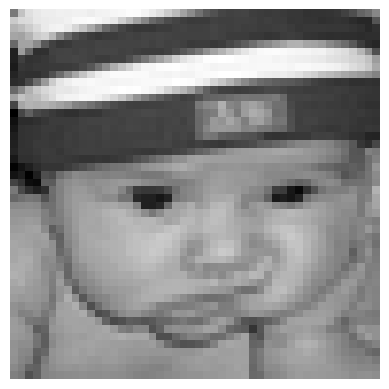

True Label: Neutral
Predicted Label: Neutral
------------------------


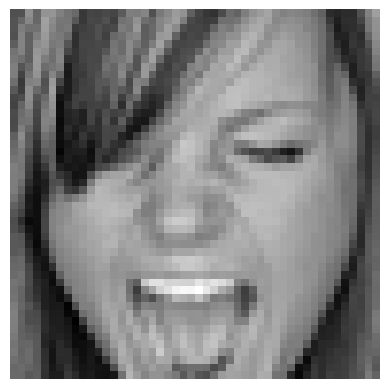

True Label: Angry
Predicted Label: Angry
------------------------


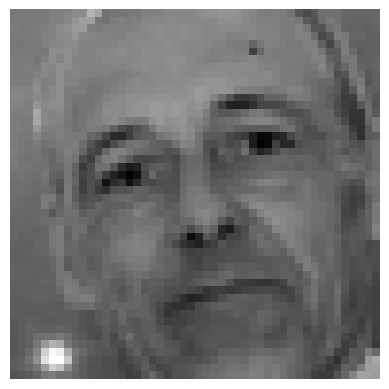

True Label: Fear
Predicted Label: Happy
------------------------


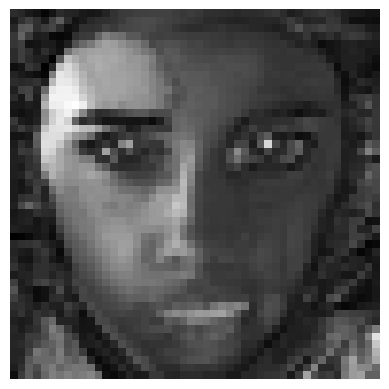

True Label: Neutral
Predicted Label: Neutral
------------------------


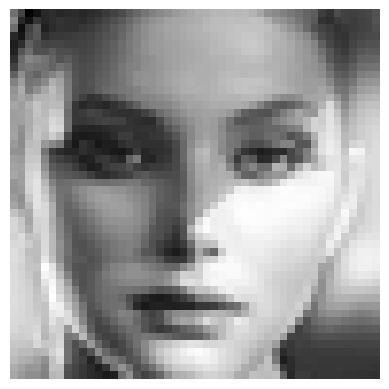

True Label: Neutral
Predicted Label: Neutral
------------------------


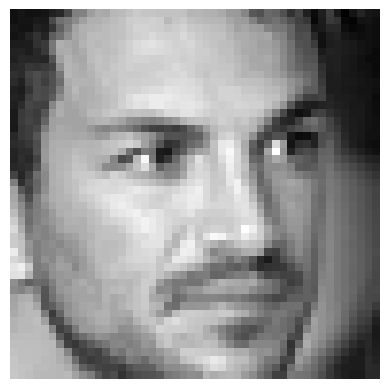

True Label: Angry
Predicted Label: Neutral
------------------------


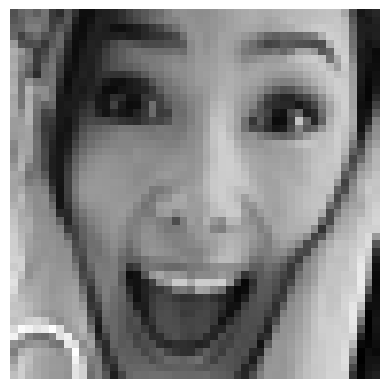

True Label: Surprise
Predicted Label: Happy
------------------------


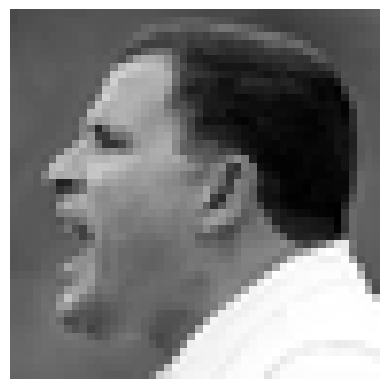

True Label: Angry
Predicted Label: Angry
------------------------


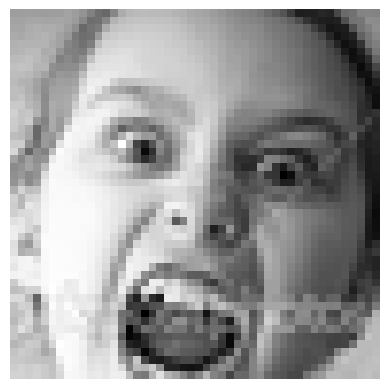

True Label: Fear
Predicted Label: Fear
------------------------


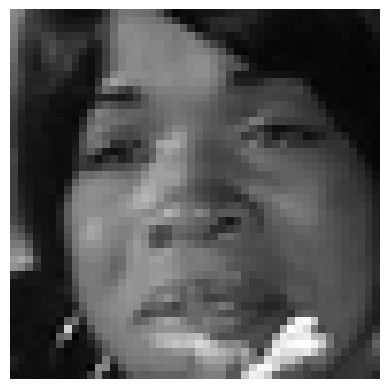

True Label: Sad
Predicted Label: Angry
------------------------


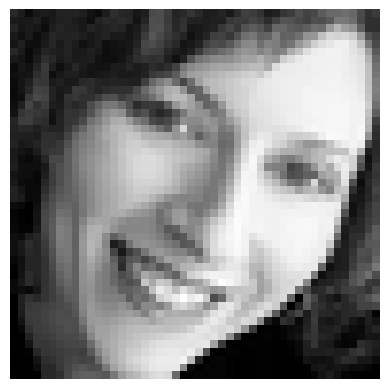

True Label: Happy
Predicted Label: Happy
------------------------


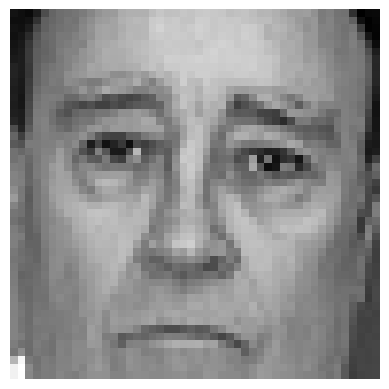

True Label: Sad
Predicted Label: Neutral
------------------------


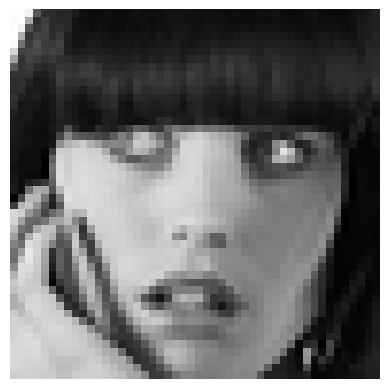

True Label: Fear
Predicted Label: Surprise
------------------------


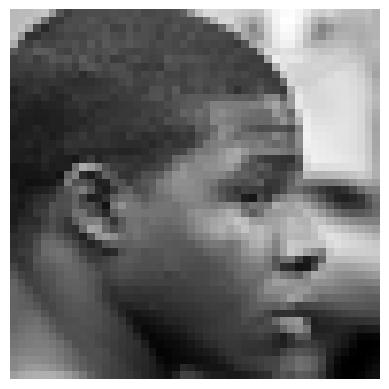

True Label: Neutral
Predicted Label: Angry
------------------------


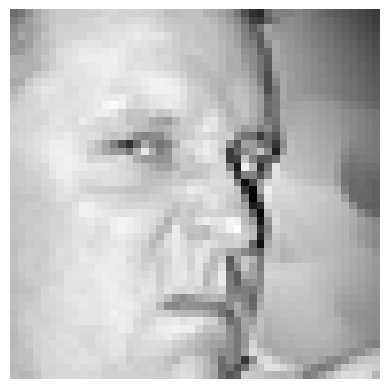

True Label: Angry
Predicted Label: Angry
------------------------


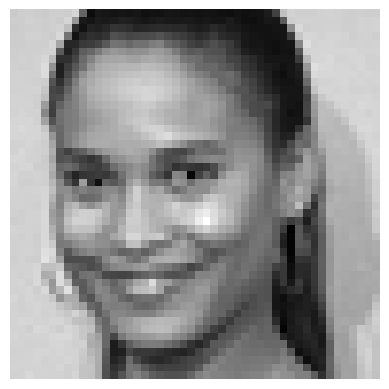

True Label: Happy
Predicted Label: Happy
------------------------


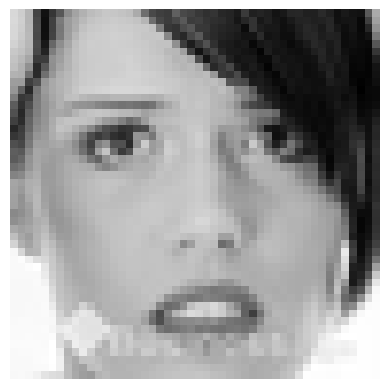

True Label: Fear
Predicted Label: Fear
------------------------


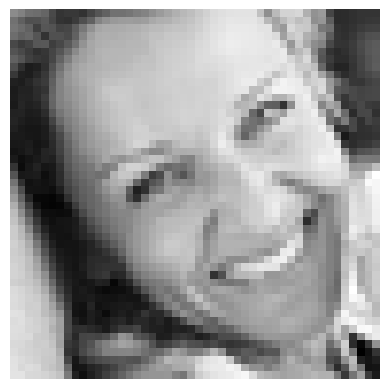

True Label: Happy
Predicted Label: Happy
------------------------


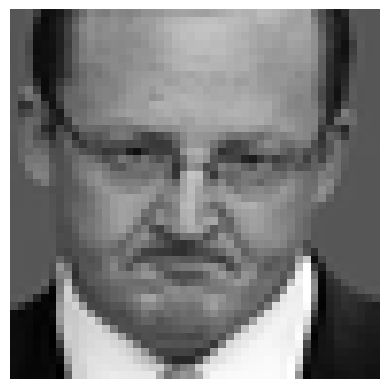

True Label: Sad
Predicted Label: Angry
------------------------


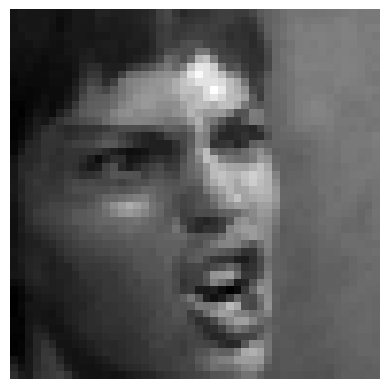

True Label: Angry
Predicted Label: Angry
------------------------


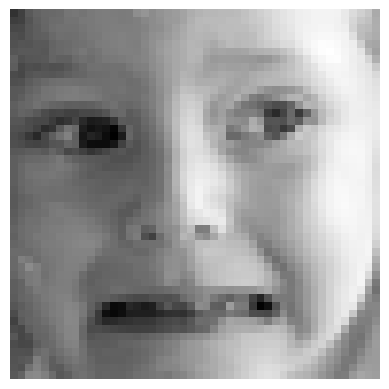

True Label: Fear
Predicted Label: Fear
------------------------


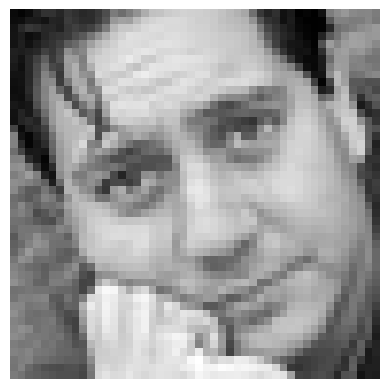

True Label: Neutral
Predicted Label: Happy
------------------------


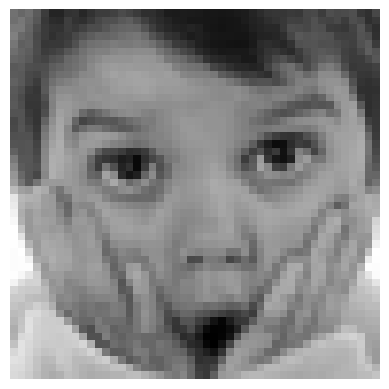

True Label: Fear
Predicted Label: Surprise
------------------------


In [ ]:
import numpy as np

# generate 25 random indices
random_indices = np.random.randint(0, len(test_images), size=25)

# loop through the indices and plot the image, true label, and predicted label
for index in random_indices:
    # plot the image
    plt.imshow(test_images[index].reshape(48, 48), cmap='gray')
    plt.axis('off')
    plt.show()
    
    # get the true label
    true_label = emotions[test_labels[index].argmax()]
    print('True Label:', true_label)
    
    # get the predicted label
    predicted_label = emotions[pred_test_labels[index].argmax()]
    print('Predicted Label:', predicted_label)
    
    print('------------------------')


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
experiment_log = []

# Example parameters to tune
num_layers_list = [1, 2, 3]
filter_sizes = [(3, 3), (5, 5), (7, 7)]
activation_functions = ['relu', 'sigmoid', 'tanh']

for num_layers in num_layers_list:
    for filter_size in filter_sizes:
        for activation_function in activation_functions:
           
            base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

            base_model = Model(inputs = base_model.input,outputs = base_model.get_layer('block_12_project_BN').output, name = 'mobilenet_trunc')
            global_average_layer = GlobalAvgPool2D()
            prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
            inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
            x = base_model(inputs_raw, training=False)

            x = global_average_layer(x)
            outputs = prediction_layer(x)
            model = Model(inputs=inputs_raw, outputs= outputs)
            
            for _ in range(num_layers):
                x = Dense(128, activation=activation_function)(x)
            predictions = Dense(7, activation='softmax')(x)  

            for layer in base_model.layers:
                layer.trainable = False

            model.compile(optimizer=Adam(lr=1e-3),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
            datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

            train_generator = datagen.flow(train_images, train_labels, batch_size=32) 

            # Train the model
            history = model.fit(
                train_images_rgb, 
                train_labels, # add train labels here
                steps_per_epoch=len(train_images_rgb), 
                epochs=100,
                validation_data=(test_images_rgb, test_labels), 
                validation_steps=len(test_images_rgb)
            )

            # Get the accuracy and loss for the current experiment
            train_loss, train_accuracy = model.evaluate(train_images_rgb, steps=len(train_images_rgb))
            test_loss, test_accuracy = model.evaluate(test_images_rgb, test_labels, steps=len(test_images_rgb))

            # Log the experiment results along with parameters
            experiment_log.append({
                'Number of layers': num_layers,
                'Filter Size Layer 1': filter_size,
                'Activation Function': activation_function,
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'Train Loss': train_loss,
                'Test Loss': test_loss
            })

            

Epoch 1/50
 1266/28709 [>.............................] - ETA: 1:55 - loss: 2.3627 - accuracy: 0.1983

KeyboardInterrupt: 